In [1]:
import numpy as np 
import time
import copy
import os
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from attack import Attack_sklearn

画像データ数:(70000, 784)
ラベルデータ数:(70000,)
 


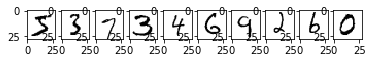

In [4]:
mnist = datasets.fetch_openml('mnist_784', version=1, data_home=".", return_X_y=True)
imagedata, labeldata = mnist[0],mnist[1]
print("画像データ数:"+str(imagedata.shape))
print("ラベルデータ数:"+str(labeldata.shape))
print(" ")
for i in range(1,11): 
    plt.subplot(1,10,i) # 横並びに表示するためのおまじない
    plt.imshow(imagedata[(i-1)*6500].reshape(28,28),cmap='gray_r')
      # データ内から適当な間隔(6500)で拾って、gray_rで白黒反転して表示してます
plt.show() 

訓練画像データ数:(11547, 784)
検証画像データ数:(2887, 784)
訓練ラベルデータ数:(11547,)
検証ラベルデータ数:(2887,)



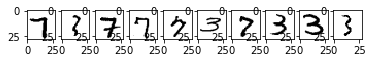

In [5]:
index_3 = [i for i, x in enumerate(labeldata) if x == "3"]
index_7 = [i for i, x in enumerate(labeldata) if x == "7"]
image_data_3_7 = imagedata[index_3 + index_7]
label_data_3_7 = labeldata[index_3 + index_7]

imagedata_training,imagedata_validation,labeldata_training,labeldata_validation = train_test_split(image_data_3_7 ,
                                                                                                   label_data_3_7,
                                                                                                   test_size=0.2, shuffle=True)
print("訓練画像データ数:"+str(imagedata_training.shape))
print("検証画像データ数:"+str(imagedata_validation.shape))
print("訓練ラベルデータ数:"+str(labeldata_training.shape))
print("検証ラベルデータ数:"+str(labeldata_validation.shape))
print("")

for i in range(1,11): 
    plt.subplot(1,10,i) # 横並びに表示するためのおまじない
    plt.imshow(imagedata_training[i-1].reshape(28,28),cmap='gray_r')
plt.show() 

In [6]:
 # 256階調の輝度値を0-1の値に変換しておきます
imagedata_training = imagedata_training/255.
imagedata_validation = imagedata_validation/255.

X_train = imagedata_training[:5000]
y_train = labeldata_training[:5000]
X_valid = imagedata_validation[:500]
y_valid = labeldata_validation[:500]

In [4]:
#np.save("data/X_train", X_train)
#np.save("data/X_valid", X_valid)
#np.save("data/y_train", y_train)
#np.save("data/y_valid", y_valid)

X_train = np.load("data/X_train.npy", allow_pickle=True) 
y_train = np.load("data/y_train.npy", allow_pickle=True)
X_valid = np.load("data/X_valid.npy", allow_pickle=True)
y_valid = np.load("data/y_valid.npy", allow_pickle=True)

In [32]:
start = time.time() # かかった時間の計測のため計算開始時刻保存
clf = SVC(kernel="rbf")
clf.fit(X_train, y_train) # 学習
elapsed_time = time.time() - start # 計算終了時刻から計算時間算出
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:2.850248098373413[sec]


In [33]:
start = time.time()
predict = clf.predict(X_valid) # 評価用データで予測
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

print("結果")
ac_score = metrics.accuracy_score(y_valid, predict) # 予測結果の答え合わせ
cl_report = metrics.classification_report(y_valid, predict)
print("正解率 = ", ac_score)
print(cl_report)

elapsed_time:0.2908172607421875[sec]
結果
正解率 =  0.994
              precision    recall  f1-score   support

           3       1.00      0.99      0.99       234
           7       0.99      1.00      0.99       266

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



In [35]:
X_minus_1 = X_train[np.where(y_train == "3")]
attacker = Attack_sklearn(clf = clf, X_minus_1 = X_minus_1,
                          dmax =  (5000 / 255) * 2.5,
                          max_iter = 300,
                          gamma = 1 / (X_train.shape[1] * np.var(X_train)),
                          lam = 10, t = 0.5, h = 10)

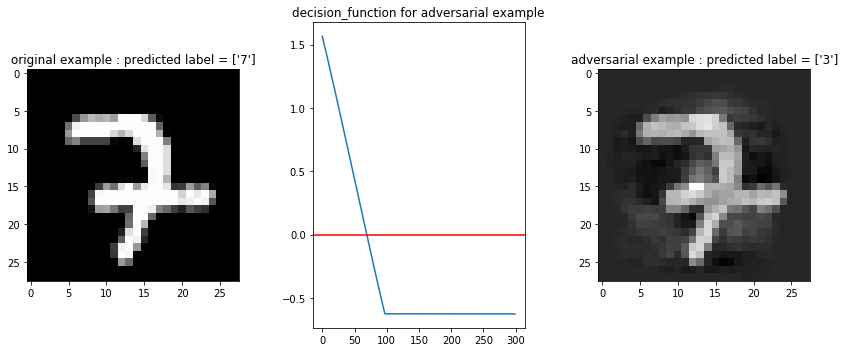

In [37]:
fig, axes= plt.subplots(1,3, figsize = (12, 5))

x0 = X_valid[4]
xm = copy.copy(x0)

axes[0].imshow(x0.reshape(28,28),cmap='gray')
axes[0].set_title(f"original example : predicted label = {clf.predict(x0.reshape(1, -1))}")

xm, g_list = attacker.attack(x0)

axes[1].plot(g_list)
axes[1].axhline(y=0, xmin=0, xmax=300, c="r")
axes[1].set_title("decision_function for adversarial example")

axes[2].imshow(xm.reshape(28,28),cmap='gray')
axes[2].set_title(f"adversarial example : predicted label = {clf.predict(xm.reshape(1, -1))}")

fig.tight_layout()
#fig.savefig("output_10.png")
fig.show()